<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/zindi_airstrip_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [162]:
%%capture
!pip -q install rasterio
!pip -q install torch
!pip -q install torchvision
!pip -q install albumentations
!pip -q install segmentation-models-pytorch
!pip -q install tqdm

In [163]:
import os
import torch
import rasterio
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download training data to local compute node

## Mount your Google Drive

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Compress training files, copy over and uncompress

In [121]:
# Navigate to the shared directory
%cd /content/drive/MyDrive/Zindi-Amazon/training
# Zip the data
!zip -r /content/images.zip images
!zip -r /content/masks.zip masks
# Unzip the files
!unzip /content/images.zip -d /content
!unzip /content/masks.zip -d /content

/content/drive/.shortcut-targets-by-id/14mw0v8Bi-MzhsqSI0K3KO23YrUHttM7P/Zindi-Amazon/training
  adding: images/ (stored 0%)
  adding: images/Sentinel_AllBands_Training_Id_20.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_59.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_61.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_78.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_79.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_105.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_120.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_135.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_139.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_138.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_66.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_176.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_157.ti

# Custom classes and functions to handle Sentinel 1/2 data and corresponding masks

In [122]:
# Custom Dataset class for Sentinel 1/2 bands and mask
class Sentinel2Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask using rasterio
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            # Extract band indexes from descriptions and read directly
            bands = {'B4': None, 'B3': None, 'B2': None}
            for i, desc in enumerate(src.descriptions):
                if desc in bands:
                    bands[desc] = src.read(i + 1)  # Read 1-based bands

            # Check if all required bands were found
            if any(value is None for value in bands.values()):
                raise ValueError(f"Not all bands found in image: {image_path}")

            # Stack the selected bands to form the final image array
            #image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
            image = np.stack([np.clip(bands['B4'],0,2000)/2000,
                              np.clip(bands['B3'],0,2000)/2000,
                              np.clip(bands['B2'],0,2000)/2000], axis=-1)

        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)

        # Ensure both image and mask are numpy arrays before applying transforms
        image = np.array(image)
        mask = np.array(mask)

        # Convert image and mask to PyTorch tensors
        #image = torch.from_numpy(image).type(torch.float32)  # Assuming image is a NumPy array
        #mask = torch.from_numpy(mask).type(torch.float32)   # Assuming mask is a NumPy array

        # Continue with your transformations and other logic:
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Only convert to PyTorch tensors if not already tensors (skip if the transform does it)
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # Channels first
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask


In [181]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='train'):
    if option == 'train':
        return A.Compose([
            A.RandomCrop(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            #A.Resize(width=224, height=224),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    elif option == 'val':
        return A.Compose([
            A.RandomCrop(height=224, width=224),  # Resize for validation
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    elif option == 'test':
        return A.Compose([
            A.RandomCrop(height=224, width=224),  # Resize for testing
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    else:
        raise ValueError("Invalid option. Choose from 'train', 'val', or 'test'.")

In [124]:
# UNet model with ResNet50 encoder
def get_model():
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=3,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [160]:
# Training loop
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    running_total_correct = 0.0

    for images, masks in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Change data type of masks to float32 before moving to device
        masks = masks.type(torch.float32).to(device).unsqueeze(1)  # Add channel dimension to masks

        images = images.float()


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(f"Loss: {loss.item()}")

        # Calculate statistics
        _, preds = torch.max(outputs, 1)

        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_total_correct += torch.sum(preds == masks)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
        print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy

In [169]:
def evaluate(model, dataloader, criterion, device, phase="val" ):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (images, masks) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    masks = masks.to(device)

    # Add channel dimension to the target masks
    masks = masks.type(torch.float32)
    masks = masks.unsqueeze(1)


    with torch.set_grad_enabled(False):
      outputs = model(images)
      loss = criterion(outputs, masks)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * images.size(0)
    running_total_correct += torch.sum(preds == masks)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [180]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer, device):
  # Keep track of the best loss and
  # best model weights with the lowest loss

  best_loss = np.inf # Initialize with a very high value
  best_model = model.state_dict() # Initialize with the initial model state

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train_model(model, train_loader, criterion, optimizer, device)
    val_loss, _ = evaluate(model, val_loader, criterion, device)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()

  # Load the best model state
  model.load_state_dict(best_model)


  return model

# Google Colab GPU
Check that the GPU enabled in your colab notebook by running the cell below.

In [126]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


# Main loop

In [127]:
image_dir = '/content/images'
mask_dir = '/content/masks'

# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

## Split into Train, Validation, and Test Sets

In [182]:
# Create dataset and dataloader

# Apply different transformations to the training, val, and test sets
train_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='train'))
val_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='val'))
test_data =  Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='test'))

# Randomly split the dataset into 80% train / 10% val / 10% test
# by subsetting the transformed train and test datasets
train_size = 0.80
val_size = 0.10
indices = list(range(int(len(train_data))))
train_split = int(train_size * len(train_data))
val_split = int(val_size * len(val_data))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 87/10/12


## Create a data loaders

In [183]:
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Visualize the data

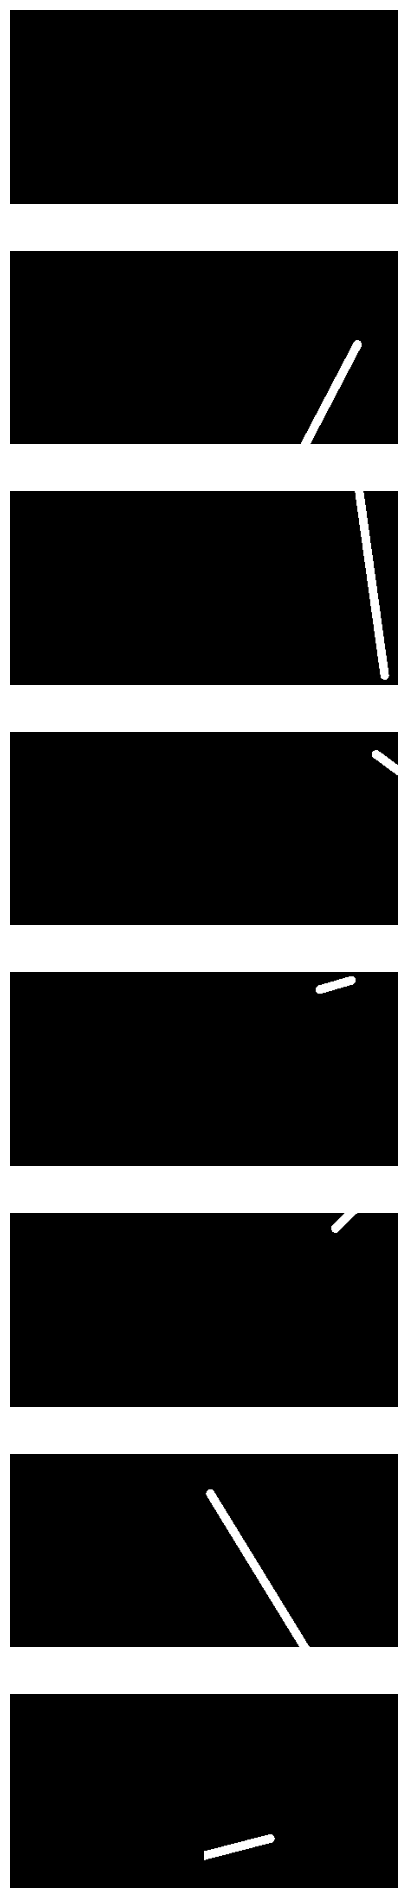

In [184]:
# You do not have to run this cell, It simply forces one iteration of the
# data loader (training) and plot the returned images and corresponding masks
# after image augmentation. This is a nice sanity check to make sure the mask
# and image still match...


images, masks = next(iter(train_loader))
fig, axes = plt.subplots(8, 2, figsize=(5, 25))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(8):
    image = torch.clamp(images[i],0,1).permute(1, 2, 0).numpy()
    mask = masks[i].squeeze().numpy()
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
plt.show()


## Instantiate the model

In [185]:
model = get_model().to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

Specify the criterion, optimizer, and hyperparameters (e.g.

1.   Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2.   Train the model on the training set by updating its weights to minimize the loss function.
3.    Evaluate the model on the test set to observe performance on new, unseen data.
4.    Repeat steps 2 and 3 n_epochs times.

In [186]:
criterion = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1




We can now commence model training and evaluation in the following cell.

In [187]:
best_model = fit(model, train_loader, val_loader, epochs, lr=0.001, criterion=criterion, optimizer=optimizer, device=device)

# Training loop
#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


Epoch 1
Train Loss: 0.05; Accuracy: 3633729.00
Train Loss: 0.10; Accuracy: 7290253.00
Train Loss: 0.15; Accuracy: 10939862.00
Train Loss: 0.19; Accuracy: 14582180.00
Train Loss: 0.22; Accuracy: 18228828.00
Train Loss: 0.25; Accuracy: 21863640.00
Train Loss: 0.28; Accuracy: 25523752.00
Train Loss: 0.31; Accuracy: 29172762.00
Train Loss: 0.34; Accuracy: 32803872.00
Train Loss: 0.36; Accuracy: 36455752.00
Train Loss: 0.38; Accuracy: 39231552.00


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]

Val Loss: 0.26; Accuracy: 33737860.00


## Model Performance on the Test Set

Using the best model from the previous steps, we can evaluate the model performance on the test set.

In [188]:
test_loss, _ = evaluate(best_model, test_loader, criterion, device=device, phase="test")

100%|██████████| 2/2 [00:08<00:00,  4.49s/it]

Test Loss: 0.27; Accuracy: 33043266.00


## Save Model

Let's define a function for saving the model to our local Google drive as follows.

In [189]:
model_dir = "/content/drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'zindi_best_model.pth')
model_file

'/content/drive/My Drive/Colab Notebooks/models/zindi_best_model.pth'

In [190]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [191]:
save_model(best_model, model_file)

Model successfully saved to /content/drive/My Drive/Colab Notebooks/models/zindi_best_model.pth.
